# Gradient Boosted Trees

So far decision trees are the most accurate models in predicting the classes. Random Forest and Gradient Boosted trees perform somewhat similarly.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from Notebook_helpers import load_data
from Notebook_helpers.modeling_helpers import *

%matplotlib inline

## Load Data

In [2]:
# df, train, val, test = load_data.load_coral_data(complete=True, CV=False, convert_to_categorical=True)
df, train, test = load_data.load_coral_data(complete=True, CV=True, convert_to_categorical=True)
print(train.shape)
# print(val.shape)

(496, 46)


## Data Prep

In [3]:
# isolate the predictors and labels for both the training and test set
train_X = train.iloc[:, 14:34]
train_y = train['Regime']

# val_X = val.iloc[:, 14:34]
# val_y = val['Regime']

pred_names = df.iloc[:, 14:34].columns
pred_names

Index(['Effluent', 'Sedimentation', 'New_Development', 'Habitat_Modification',
       'Invasive_Algae', 'Fishing_Comm_Total', 'Fishing_NonComm_Boat_Total',
       'Fishing_NonComm_Shore_Line', 'Fishing_NonComm_Shore_Net',
       'Fishing_NonComm_Shore_Spear', 'SST_CLIM_M', 'SST_STD', 'CHL_CLIM_M',
       'CHL_ANOM_F', 'PAR_CLIM_M', 'PAR_STD', 'WAV_CLIM_M', 'WAV_ANOM_F',
       'Complexity', 'Depth'],
      dtype='object')

In [4]:
import time

In [5]:
begin = time.time()

for i in range(100000):
    i
    
print("That took {} seconds".format(time.time() - begin))

That took 0.007101297378540039 seconds


# Try Cross Validation Code from Logistic

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, zero_one_loss
import time
num_trees = [1, 10, 50, 100, 150, 200, 250, 300]
depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
hyperparameters = dict(n_estimators=num_trees, max_depth=depth)

begin = time.time()
clf = GridSearchCV(sklearn.ensemble.GradientBoostingClassifier(random_state=229), 
                  hyperparameters, cv=5, verbose=1, iid=False,
                  scoring = make_scorer(metrics.f1_score, average='micro', greater_is_better=True),
                  return_train_score=True)
best_model = clf.fit(train_X, train_y)

print("That took {} seconds".format(time.time() - begin))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


That took 197.2993061542511 seconds


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  3.3min finished


In [7]:
# # Best Model is the model picked with the optimal C retrained on the
# # entire training data.

print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])

Best n_estimators: 50
Best max_depth: 3


In [8]:
# from scikit-learn, "Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV" 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
results = clf.cv_results_

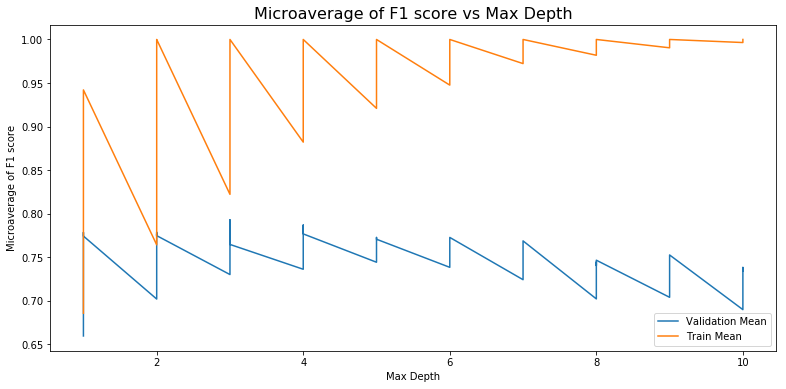

In [11]:
plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs Max Depth",
          fontsize=16)

plt.xlabel("Max Depth")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()
# plt.xscale("log")
# ax.set_xlim(C[0], C[-1])

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_max_depth'].data, dtype=float)

sample_score_mean = results['mean_test_score']
# sample_score_std = results['std_test_score']

train_score_mean = results['mean_train_score']

# add error bars
plt.errorbar(x = X_axis, y = sample_score_mean, 
             label='Validation Mean', capsize=4, capthick=2)
plt.errorbar(x = X_axis, y = train_score_mean, 
             label='Train Mean', capsize=4, capthick=2)

plt.legend()

plt.grid(False)
plt.show()

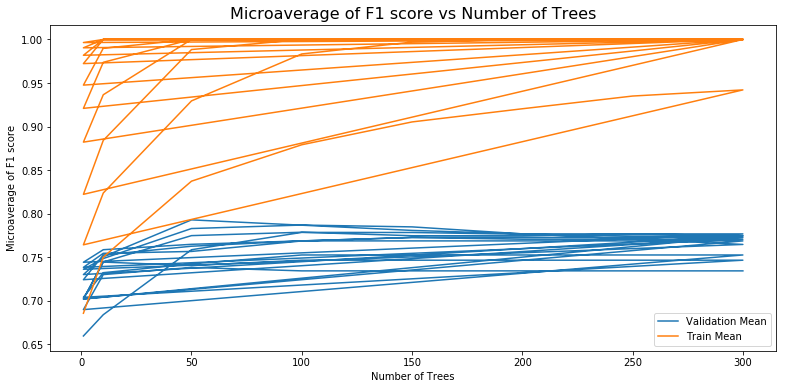

In [12]:
plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs Number of Trees",
          fontsize=16)

plt.xlabel("Number of Trees")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()
# plt.xscale("log")
# ax.set_xlim(C[0], C[-1])

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)

sample_score_mean = results['mean_test_score']
# sample_score_std = results['std_test_score']

train_score_mean = results['mean_train_score']

# add error bars
plt.errorbar(x = X_axis, y = sample_score_mean, 
             label='Validation Mean', capsize=4, capthick=2)
plt.errorbar(x = X_axis, y = train_score_mean, 
             label='Train Mean', capsize=4, capthick=2)

plt.legend()

plt.grid(False)
plt.show()

# ------------------------------------------------------------------------------------------

In [7]:
gb_model = sklearn.ensemble.GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=229)
gb_model.fit(train_X, train_y)

estimates = gb_model.predict(val_X)

#### evaluate performance

Misclassified samples: 18
Classification Report:
              precision    recall  f1-score   support

           1       0.90      1.00      0.95        26
           2       0.89      0.89      0.89        28
           3       0.70      0.76      0.73        25
           5       0.75      0.57      0.65        21

   micro avg       0.82      0.82      0.82       100
   macro avg       0.81      0.81      0.80       100
weighted avg       0.82      0.82      0.81       100



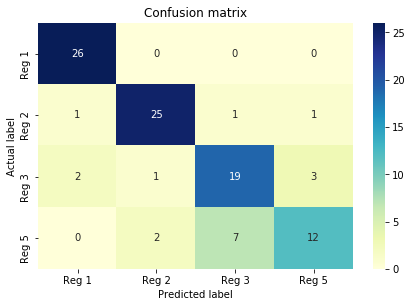

In [9]:
evaluate_performance(val_y, estimates)

# Cross-Validation: n_estimators

In [11]:
num_trees = [1, 10, 50, 100, 150, 200, 250, 300]
train_accuracies = []
val_accuracies = []
for n in num_trees:
    gb_model = sklearn.ensemble.GradientBoostingClassifier(n_estimators=n, max_depth=3, random_state=229)
    gb_model.fit(train_X, train_y)

    train_estimates = gb_model.predict(train_X)
    train_accuracies.append(metrics.accuracy_score(train_y, train_estimates))
    
    val_estimates = gb_model.predict(val_X)
    val_accuracies.append(metrics.accuracy_score(val_y, val_estimates))

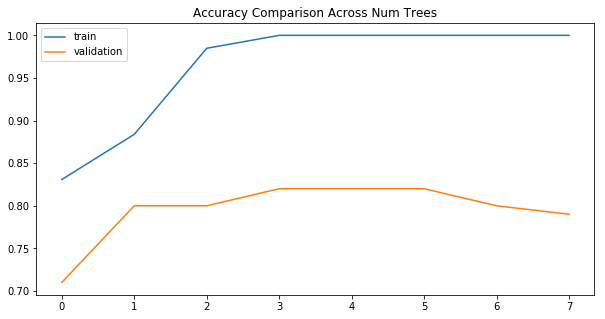

In [13]:
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label="train")
plt.plot(val_accuracies, label="validation")
plt.legend()
plt.title("Accuracy Comparison Across Num Trees")
plt.show()

# Cross-Validation: max_depth

In [21]:
# num_trees = [1, 10, 50, 100, 150, 200, 250, 300]
depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_accuracies = []
val_accuracies = []
for d in depth:
    gb_model = sklearn.ensemble.GradientBoostingClassifier(n_estimators=100, max_depth=d, random_state=229)
    gb_model.fit(train_X, train_y)

    train_estimates = gb_model.predict(train_X)
    train_accuracies.append(metrics.accuracy_score(train_y, train_estimates))
    
    val_estimates = gb_model.predict(val_X)
    val_accuracies.append(metrics.accuracy_score(val_y, val_estimates))

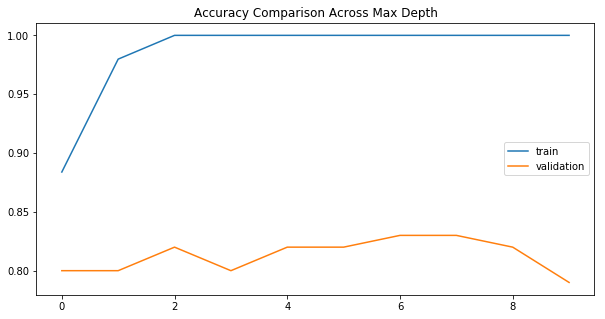

In [22]:
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label="train")
plt.plot(val_accuracies, label="validation")
plt.legend()
plt.title("Accuracy Comparison Across Max Depth")
plt.show()

# Train Best Model

In [5]:
gb_model = sklearn.ensemble.GradientBoostingClassifier(n_estimators=100, max_depth=6, random_state=229)
gb_model.fit(train_X, train_y)

train_estimates = gb_model.predict(train_X)

val_estimates = gb_model.predict(val_X)

Misclassified samples: 18
Classification Report:
              precision    recall  f1-score   support

           1       0.87      1.00      0.93        26
           2       0.93      0.89      0.91        28
           3       0.73      0.64      0.68        25
           5       0.71      0.71      0.71        21

   micro avg       0.82      0.82      0.82       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.82      0.82      0.82       100



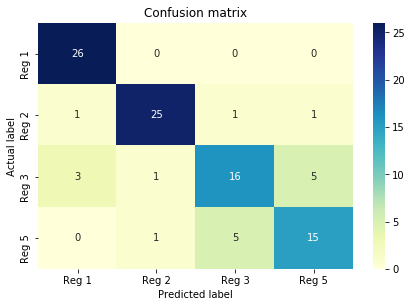

In [6]:
# evaluate_performance(train_y, train_estimates)
evaluate_performance(val_y, val_estimates)

# Error Analysis

The model does really well predicting Regimes 1 and 2, but seems to mistake Regimes 3 and 5 about 25% of the time. 

In [ ]:
#What are the confidence scores for those predictions? 
# how do those confidence scores relate to the other predictions?

# are the predictors similar for those regimes? More similar than the others?

In [8]:
val_probs = gb_model.predict_proba(val_X)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [42]:
comb = pd.DataFrame({"val_y":val_y, "val_est":val_estimates})
misclass_idxs = np.where(val_y != val_estimates)
print(len(misclass_idxs[0]))

18


In [40]:
comb.loc[misclass_idxs]

,val_y,val_est
5,3,5
19,3,5
23,3,1
30,3,5
36,5,3
37,3,5
46,3,5
51,2,3
53,2,5
56,5,2


In [28]:
def to_0_3(array):
    array = array.copy()
    array[array==1] = 0
    array[array==2] = 1
    array[array==3] = 2
    array[array==5] = 3
    return array
    
def back_to_1_5(array):
    array = array.copy()
    array[array==3] = 5
    array[array==2] = 3
    array[array==1] = 2
    array[array==0] = 1
    return array

In [48]:
predicted_class_probs = val_probs[range(100),to_0_3(val_estimates)]
misclasses = predicted_class_probs[np.where(val_y != val_estimates)]
misclasses

array([0.99991639, 0.62002004, 0.76083493, 0.98640123, 0.99786503,
       0.71640264, 0.99399373, 0.99966789, 0.95693121, 0.99935088,
       0.99695948, 0.53198882, 0.89982328, 0.95610743, 0.99981668,
       0.94082312, 0.55474928, 0.98910805])

In [47]:
fives_threes = [0,1,3,4,5,6,10,13,16,17]
misclasses[fives_threes]

array([0.99991639, 0.62002004, 0.98640123, 0.99786503, 0.71640264,
       0.99399373, 0.99695948, 0.95610743, 0.55474928, 0.98910805])

Text(0.5, 1.0, "Probability of Misclasses of 3's as 5's")

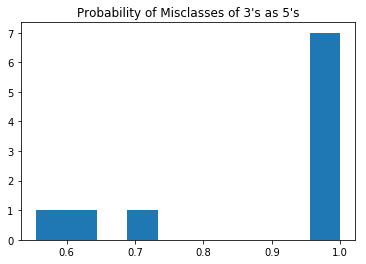

In [53]:
plt.hist(misclasses[fives_threes])
plt.title("Probability of Misclasses of 3's as 5's")

It's pretty confident when it's misclassifying between 3's and 5's

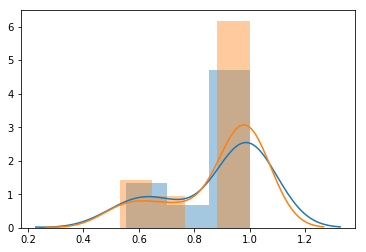

In [57]:
sns.distplot(misclasses[fives_threes], norm_hist=True)
sns.distplot(misclasses, norm_hist=True)

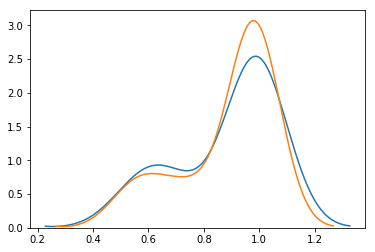

In [65]:
sns.distplot(misclasses[fives_threes], hist=False)
sns.distplot(misclasses, hist=False)